In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from scipy.interpolate import interpn
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')

In [13]:
def x_inf(x,y,sigma):
    # Special code here to make sure it's defined along some singular lines
    return np.where((y>0)+(x!=1/sigma0),-1./sigma * np.real(lambertw(-x*sigma*np.exp(-sigma*(x+y)))),x)
#def x_inf(x,y,sigma):
#    return -1./sigma * np.real(lambertw(-x*sigma*np.exp(-sigma*(x+y))))

def mu(x,y,sigma):
    return x*np.exp(-sigma*(x+y))

def dxinf_dy(x,y,sigma):
    xinf = x_inf(x,y,sigma)
    return -sigma*xinf/(1-sigma*xinf)

In [3]:
def sigma_opt(x,y,u,c2,sigma0,gamma):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    dudy = np.zeros_like(u)
    dudx = np.zeros_like(u)
    
    # Centered difference: (maybe we should use left/right depending on whether x>1/sigma_0)
    dudy[:,1:-1] = 0.5*(u[:,2:] - u[:,:-2])/dy
    # Left difference: (since susceptibles only increase in backward time)
    dudx[1:,:] = (u[1:,:]-u[:-1,:])/dx
    
    return sigma0*min(1,max(0,1-sigma0/(2*c2) * gamma*x*y*(dudy-dudx)))

In [4]:
beta = 0.3
gamma = 0.1
sigma0 = beta/gamma
c2 = 1.e-3
tfinal = 10

mx, my, mt = 100, 100, 1000
x, y, t = np.ogrid[0:1:mx*1j, 0:1:my*1j, 0:tfinal:mt*1j]
#xx, yy, tt = np.mgrid[0:1:mx*1j, 0:1:my*1j, 0:100:mt*1j]
x, y = np.ogrid[0:1:mx*1j, 0:1:my*1j]
dx = x[1,0]-x[0,0]
dy = y[0,1]-y[0,0]
dt = t[0,0,1]-t[0,0,0]
u = np.zeros((mx,my,mt))
u[:,:,0] = -x_inf(x,y,sigma0).squeeze()
sigma_opt = np.zeros_like(u)

dudy = np.zeros((mx,my))
dudy_down = np.zeros((mx,my))
dudy_up = np.zeros((mx,my))
dudx = np.zeros((mx,my))

one = np.ones_like(dudx)
zero = np.zeros_like(dudx)

for it in range(mt-1):
    print(it/mt)
    dudy_down[:,1:] = (u[:,1:,it] - u[:,:-1,it])/dy
    dudy_up[:,:-1] = (u[:,1:,it] - u[:,:-1,it])/dy
    sigma_opt[:,:,it] = sigma0*np.minimum(one,np.maximum(zero,(1-sigma0/(2*c2)*gamma*x*y*((dudy_down+dudy_up)/2.-dudx))))
    dydt = gamma*y*(sigma_opt[:,:,it]*x-1)
    dudy = np.where(dydt<0,dudy_down,dudy_up)
    dudx[1:,:] = (u[1:,:,it]-u[:-1,:,it])/dx
    sigma_opt[:,:,it] = sigma0*np.minimum(one,np.maximum(zero,(1-sigma0/(2*c2)*gamma*x*y*(dudy-dudx))))
    u[:,:,it+1] = u[:,:,it] + dt*(gamma*x*y*sigma_opt[:,:,it]*(dudy-dudx)+ \
                                  c2*(1-sigma_opt[:,:,it]/sigma0)**2-gamma*y*dudy)
    u[:,:,it+1] = np.where(x+y<1,u[:,:,it+1],0*u[:,:,0])

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052
0.053
0.054
0.055
0.056
0.057
0.058
0.059
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.071
0.072
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.086
0.087
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169

In [5]:
sigma_opt[0,:,:]=sigma_opt[1,:,:]
sigma_opt[:,0,:]=sigma_opt[:,1,:]
sigma_opt[:,:,-1] = sigma_opt[:,:,-2]

# Now solve the ODE with the optimal control

In [6]:
ttt = t.copy()
T = tfinal

def rhs(t, v):
    # Variables: x, y, lambda_1, lambda_2
    dv = np.zeros(2)

    sigma = interpn((x.squeeze(),y.squeeze(),ttt.squeeze()),sigma_opt,(v[0],v[1],T-t))
    #print(t,sigma)

    dv[0] = -sigma*gamma*v[1]*v[0]
    dv[1] =  sigma*gamma*v[1]*v[0] - gamma*v[1]

    return dv

y0 = 0.01 # Initial infected
x0 = 0.99
v0 = np.array((x0,y0))
times = np.arange(0,T)

solution = solve_ivp(rhs,[0,T],v0,t_eval=times,method='RK23',rtol=1.e-3,atol=1.e-3,max_step=5e-2)

In [7]:
def sigmastar(v,t):
    return interpn((x.squeeze(),y.squeeze(),ttt.squeeze()),sigma_opt,(v[0],v[1],T-t))

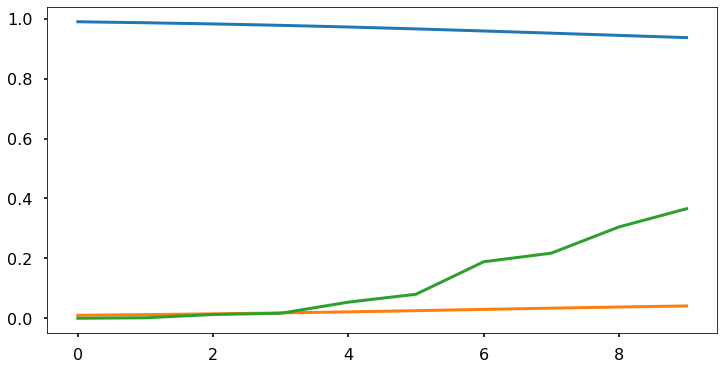

In [8]:
xsol = solution.y[0,:]
ysol = solution.y[1,:]
sigma = sigmastar(solution.y,solution.t)
plt.figure(figsize=(12,6))
plt.plot(times,xsol,lw=3);
plt.plot(times,ysol,lw=3);
plt.plot(times,1-sigma/sigma0,lw=3)

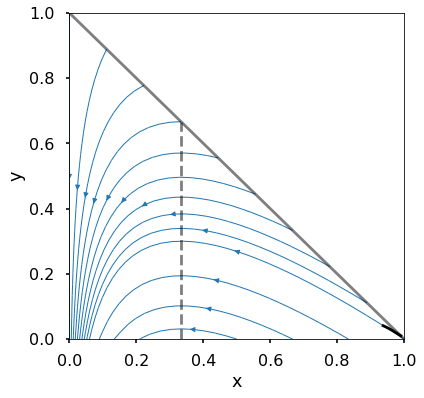

In [9]:
N1 = 10; N2=5
Y, X = np.mgrid[0:1:100j, 0:1:100j]
U = -beta*X*Y
V = beta*X*Y - gamma*Y
x_points = list(np.linspace(0,1,N1)) + list(np.linspace(1./sigma0,1,N2))
y_points = list(1.-np.linspace(0,1,N1)) + [1.e-6]*N2
seed_points = np.array([x_points, y_points])

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, start_points=seed_points.T,integration_direction='forward',maxlength=1000,
               broken_streamlines=False,linewidth=1)
plt.plot([0,1],[1,0],'-k',alpha=0.5)
plt.plot(xsol,ysol,'-k')
plt.plot([gamma/beta, gamma/beta],[0,1-gamma/beta],'--k',alpha=0.5)
plt.xlim(0,1); plt.ylim(0,1);
plt.xlabel('x'); plt.ylabel('y');

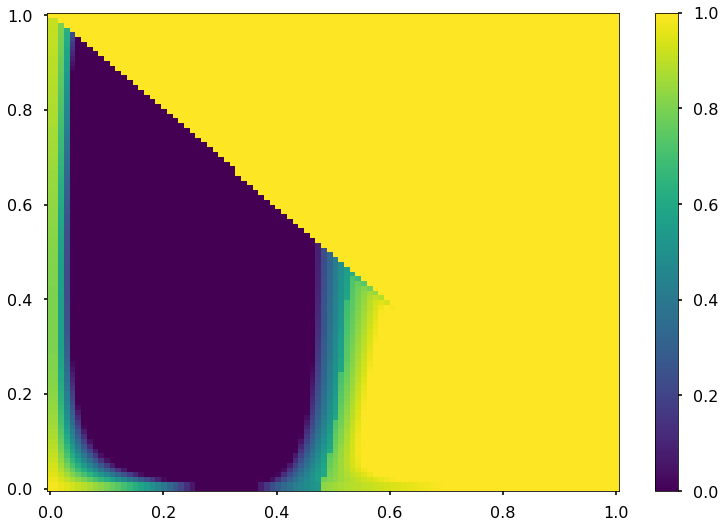

In [10]:
plt.pcolor(x+0*y,y+0*x,sigma_opt[:,:,-1]/sigma0,shading='auto')
plt.colorbar()

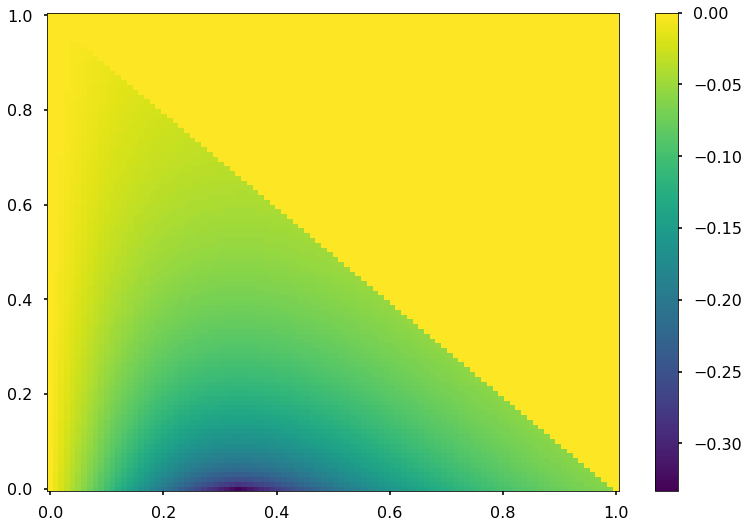

In [11]:
plt.pcolor(x+0*y,y+0*x,u[:,:,500],shading='auto')
plt.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The following kwargs were not used by contour: 'shading'
  """Entry point for launching an IPython kernel.


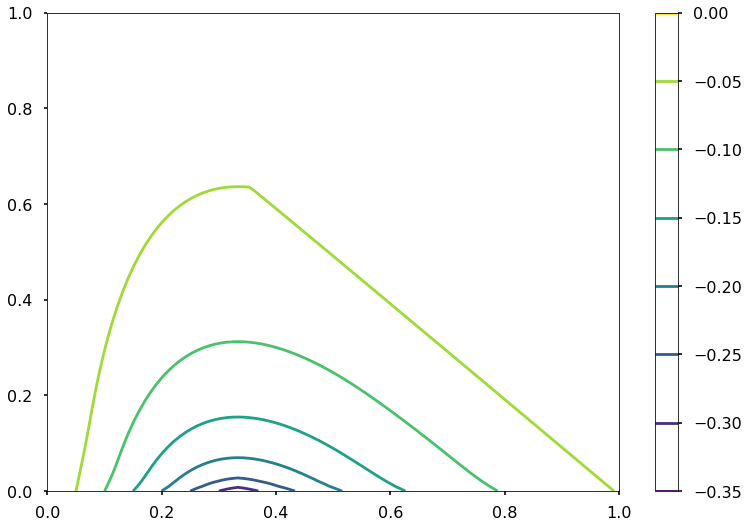

In [12]:
plt.contour(x+0*y,y+0*x,u[:,:,700],shading='auto')
plt.colorbar()